In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from itertools import islice
from pathlib import Path
import os

import flax.linen as nn
import h5py
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import optax
import pandas as pd
import seaborn as sns
from flax.training import train_state
from jax import random
from sklearn.manifold import TSNE

from neurovae import Conv1DVAE, sse_loss, gaussian_kld, reparameterize
from helper import fig_path

sns.set_theme(context="paper", style="darkgrid", rc={"axes.facecolor": "0.96"})
fontsize = "x-large"
params = {
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern"],
    "axes.labelsize": fontsize,
    "legend.fontsize": fontsize,
    "xtick.labelsize": fontsize,
    "ytick.labelsize": fontsize,
    "legend.handlelength": 2,
}
plt.rcParams.update(params)

2024-06-24 17:30:35.728976: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def run(beta, latent_dim):
    def create_batches(data, batch_size, drop_remainder):

        data_size = data.shape[0]
        remainder = data_size % batch_size

        if drop_remainder and remainder != 0:
            it = iter(data[: data_size - remainder, :])
        else:
            it = iter(data)

        batches = []

        while batch := tuple(islice(it, batch_size)):
            batches.append(jnp.asarray(batch))

        return batches

    output_dim = 5000
    batch_size = 16
    epochs = 100
    seed = 42

    # prepare HH data
    t_sim = 100.0
    dt = 0.01
    N = int(t_sim / dt)
    t = np.linspace(0, t_sim, N)

    vs = []
    for i in range(10):
        infile = f"./hh_data/hh_sim_data_{i}.h5"
        with h5py.File(infile, "r") as f:
            for grp_name in f.keys():
                v = f[grp_name]["v"][:]
                v_scaled = (v - v.min(keepdims=True)) / (v.max(keepdims=True) - v.min(keepdims=True))
                vs.append(v_scaled[:output_dim])

    v_train = vs[:8000]
    v_test = vs[8000:]

    # cast to jax
    v_train = jnp.asarray(v_train, dtype=jnp.float32)
    v_test = jnp.asarray(v_test, dtype=jnp.float32)

    batches = create_batches(v_train, batch_size, drop_remainder=True)

    # set values for learning rate scheduler
    total_steps = len(batches) * epochs
    init_lr = 1e-3
    alpha_lr = 1e-2


    def model():
        return Conv1DVAE(latent_dim, output_dim)


    def init_model(rng):
        rng, init_key = random.split(rng)

        initial_variables = jnp.ones((batch_size, output_dim), jnp.float32)
        params = model().init(init_key, initial_variables, rng)["params"]
        del initial_variables, init_key

        lr_schedule = optax.cosine_decay_schedule(init_lr, decay_steps=total_steps, alpha=alpha_lr)
        optimizer = optax.chain(optax.clip(1.0), optax.adamw(lr_schedule, nesterov=True))

        state = train_state.TrainState.create(
            apply_fn=model().apply,
            params=params,
            tx=optimizer,
        )
        return rng, state


    def compute_metrics(recon_x, x, mean, logvar):
        mse = sse_loss(recon_x, x).mean()  # mean over batch
        kld = gaussian_kld(mean, logvar).mean()  # mean over batch
        elbo = mse + beta * kld
        return {"elbo": elbo, "mse": mse, "kld": kld}


    @jax.jit
    def train_step(state, batch, z_rng):

        def loss_fn(params):
            recon_x, mean, logvar = model().apply({"params": params}, batch, z_rng)
            mse = sse_loss(recon_x, batch).mean()
            kld = gaussian_kld(mean, logvar).mean()
            elbo = mse + beta * kld
            return elbo

        grads = jax.grad(loss_fn)(state.params)
        return state.apply_gradients(grads=grads)


    @jax.jit
    def eval_f(params, v_traces, z, z_rng):
        def eval_model(vae):
            recon_v_traces, mean, logvar = vae(v_traces, z_rng)

            comparison = jnp.concatenate(
                [
                    v_traces[:8],
                    recon_v_traces[:8],
                ]
            )

            generate_v_traces = vae.generate(z, assumption="gaussian")
            metrics = compute_metrics(recon_v_traces, v_traces, mean, logvar)
            return metrics, comparison, generate_v_traces

        return nn.apply(eval_model, model())({"params": params})


    rng = random.key(seed)
    rng, state = init_model(rng)

    rng, z_key, eval_rng = random.split(rng, 3)

    z = random.normal(z_key, (batch_size, latent_dim))  # prior
    del z_key

    epoch_metrics = []
    for epoch in range(epochs):
        for batch in batches:
            rng, key = random.split(rng)
            state = train_step(state, batch, key)

        metrics, comparison, samples = eval_f(state.params, v_test, z, eval_rng)
        metrics["epoch"] = epoch + 1
        epoch_metrics.append(metrics)
        print(f"epoch: {epoch + 1}, ELBO: {metrics['elbo']:.4f}, MSE: {metrics['mse']:.4f}, KLD: {metrics['kld']:.4f}")

    df = pd.DataFrame(epoch_metrics)
    df.to_csv(f"./vae_data/hh_beta_{beta}_z_{latent_dim}_conv_vae.csv", index=False)

    v_org = comparison[:8]
    v_recon = comparison[8:]
    t = t[:output_dim]

    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(8, 6), tight_layout=True)

    axes[0, 0].plot(t, v_recon[0], "C0")
    axes[0, 0].plot(t, v_org[0], "C1")
    axes[0, 0].set(ylabel="Voltage", xticks=[])

    axes[0, 1].plot(t, v_recon[1], "C0")
    axes[0, 1].plot(t, v_org[1], "C1")
    axes[0, 1].set(xticks=[], yticks=[])

    axes[0, 2].plot(t, v_recon[2], "C0")
    axes[0, 2].plot(t, v_org[2], "C1")
    axes[0, 2].set(xticks=[], yticks=[])

    axes[1, 0].plot(t, v_recon[3], "C0")
    axes[1, 0].plot(t, v_org[3], "C1")
    axes[1, 0].set(ylabel="Voltage", xticks=[])

    axes[1, 1].plot(t, v_recon[4], "C0")
    axes[1, 1].plot(t, v_org[4], "C1")
    axes[1, 1].set(xticks=[], yticks=[])

    axes[1, 2].plot(t, v_recon[5], "C0", label="Reconstructed")
    axes[1, 2].plot(t, v_org[5], "C1", label="Original")
    axes[1, 2].set(xticks=[], yticks=[])
    axes[1, 2].plot([], [], "C2", label="Generated")

    axes[2, 0].plot(t, samples[0], "C2")
    axes[2, 0].set(xlabel="Time", ylabel="Voltage")
    axes[2, 1].plot(t, samples[1], "C2")
    axes[2, 1].set(xlabel="Time", yticks=[])
    axes[2, 2].plot(t, samples[2], "C2")
    axes[2, 2].set(xlabel="Time", yticks=[])

    handles, labels = axes[1, 2].get_legend_handles_labels()
    axes[1, 2].legend(
        handles,
        labels,
        loc="center left",
        bbox_to_anchor=(1.04, 0.5),
        fancybox=True,
        borderaxespad=0.1,
        ncol=1,
        frameon=False,
    )

    fig.savefig(fig_path(f"hh_conv_vae_beta_{beta}_z_{latent_dim}.pdf"), bbox_inches="tight")

    enc_rng = random.key(seed * seed)
    _, mean, logvar = model().apply({"params": state.params}, v_test, enc_rng)
    z = reparameterize(enc_rng, mean, logvar)
    z = np.array(z)
    z_embedded = TSNE(n_components=2, learning_rate="auto", perplexity=30, early_exaggeration=12.0).fit_transform(z)

    fig = plt.figure()
    plt.scatter(z_embedded[:, 0], z_embedded[:, 1])
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)

    fig.savefig(fig_path(f"hh_tsne_conv_vae_beta_{beta}_z_{latent_dim}.pdf"), bbox_inches="tight")

2024-06-24 17:30:53.675142: E external/xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[2000,64,5000]{2,1,0}, u8[0]{0}) custom-call(f32[2000,64,5000]{2,1,0}, f32[64,64,3]{2,1,0}, f32[64]{0}), window={size=3 pad=1_1}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2024-06-24 17:30:53.686266: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.011345993s
Trying algorithm eng0{} for conv (f32[2000,64,5000]{2,1,0}, u8[0]{0}) custom-call(f32[2000,64,5000]{2,1,0}, f32[64,64,3]{2,1,0}, f32[64]{0}), window={size=3 pad=1_1}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_q

epoch: 1, ELBO: 38.9432, MSE: 22.0479, KLD: 16.8953
epoch: 2, ELBO: 29.2396, MSE: 15.4979, KLD: 13.7416
epoch: 3, ELBO: 23.0668, MSE: 11.3306, KLD: 11.7361
epoch: 4, ELBO: 22.6095, MSE: 11.3731, KLD: 11.2364
epoch: 5, ELBO: 17.7413, MSE: 7.8836, KLD: 9.8577
epoch: 6, ELBO: 15.4297, MSE: 6.7917, KLD: 8.6380
epoch: 7, ELBO: 16.3422, MSE: 8.4700, KLD: 7.8723
epoch: 8, ELBO: 12.6264, MSE: 5.3091, KLD: 7.3173
epoch: 9, ELBO: 12.6089, MSE: 5.4773, KLD: 7.1316
epoch: 10, ELBO: 11.4230, MSE: 5.0482, KLD: 6.3748
epoch: 11, ELBO: 11.6190, MSE: 5.0641, KLD: 6.5549
epoch: 12, ELBO: 12.3064, MSE: 5.9684, KLD: 6.3380
epoch: 13, ELBO: 10.9812, MSE: 5.2373, KLD: 5.7439
epoch: 14, ELBO: 10.3112, MSE: 4.7171, KLD: 5.5941
epoch: 15, ELBO: 10.6429, MSE: 5.0616, KLD: 5.5813
epoch: 16, ELBO: 9.6590, MSE: 4.4467, KLD: 5.2123
epoch: 17, ELBO: 9.9358, MSE: 4.5294, KLD: 5.4065
epoch: 18, ELBO: 8.8570, MSE: 3.2429, KLD: 5.6141
epoch: 19, ELBO: 10.2982, MSE: 4.4969, KLD: 5.8013
epoch: 20, ELBO: 9.7031, MSE: 4.672

2024-06-24 17:32:49.992335: E external/xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[2000,64,5000]{2,1,0}, u8[0]{0}) custom-call(f32[2000,64,5000]{2,1,0}, f32[64,64,3]{2,1,0}), window={size=3 pad=1_1}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2024-06-24 17:32:49.997308: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.005092415s
Trying algorithm eng0{} for conv (f32[2000,64,5000]{2,1,0}, u8[0]{0}) custom-call(f32[2000,64,5000]{2,1,0}, f32[64,64,3]{2,1,0}), window={size=3 pad=1_1}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_

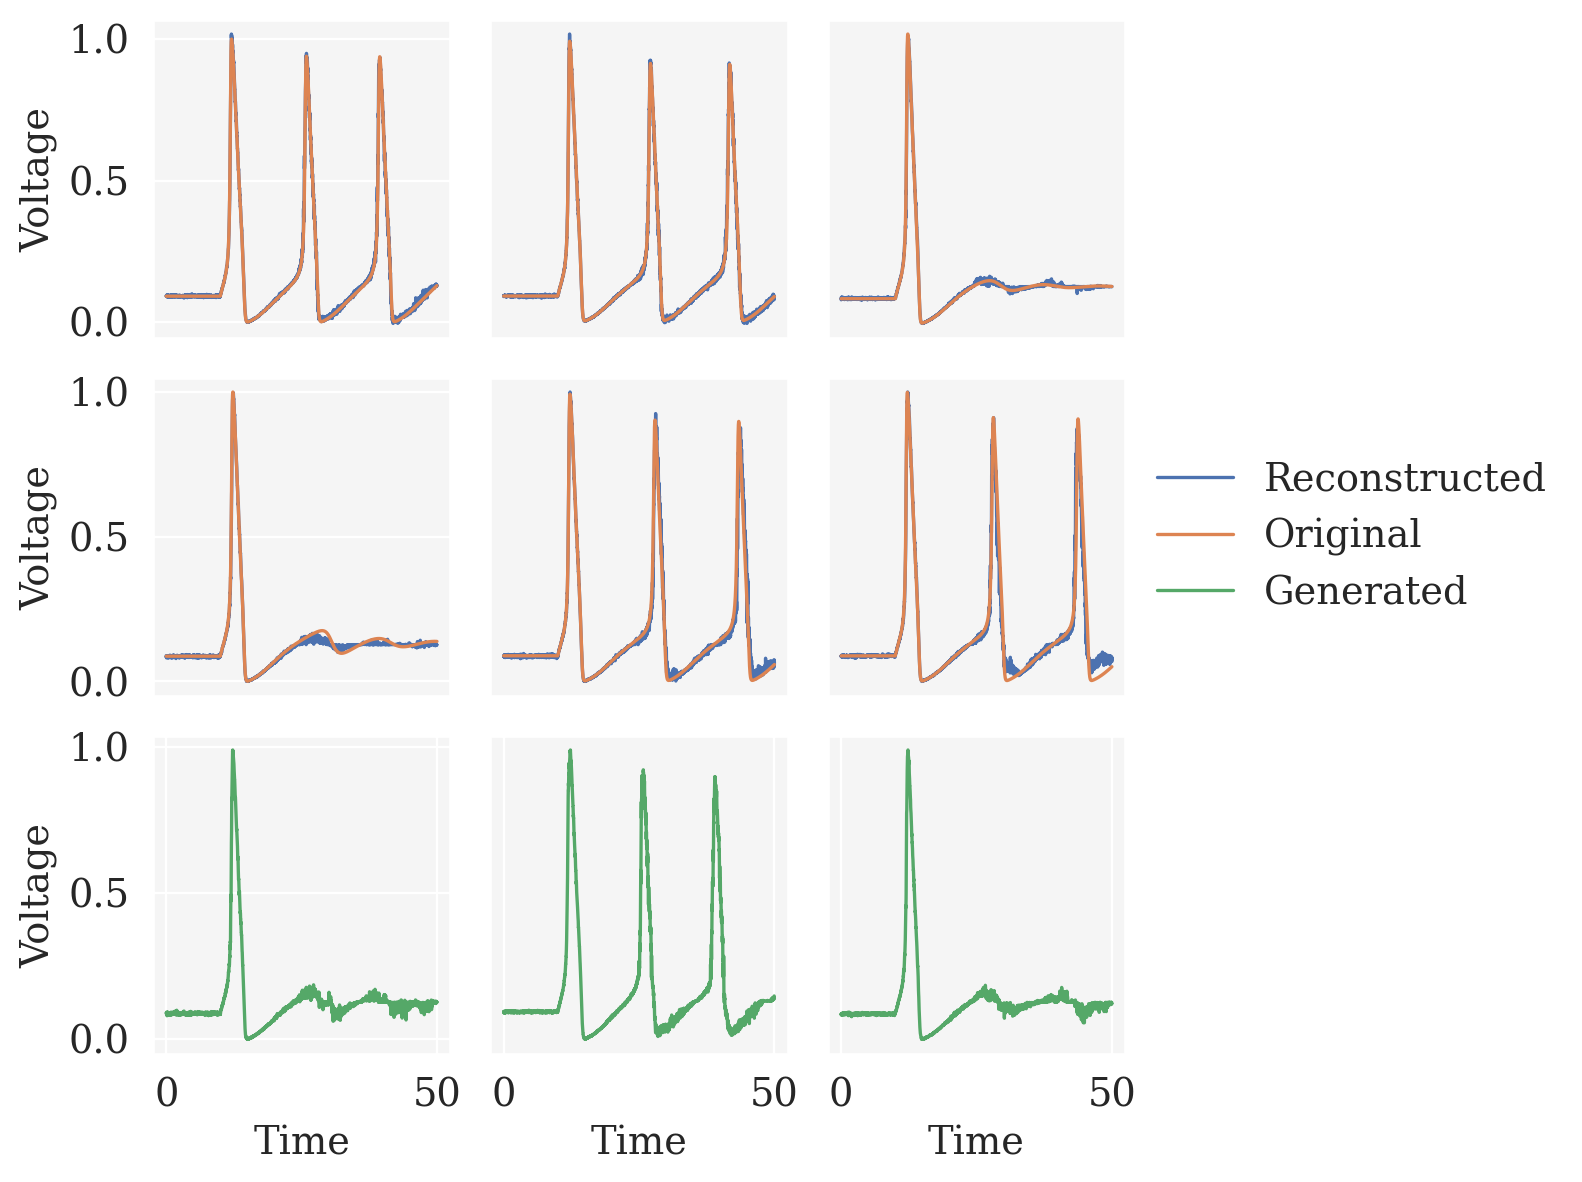

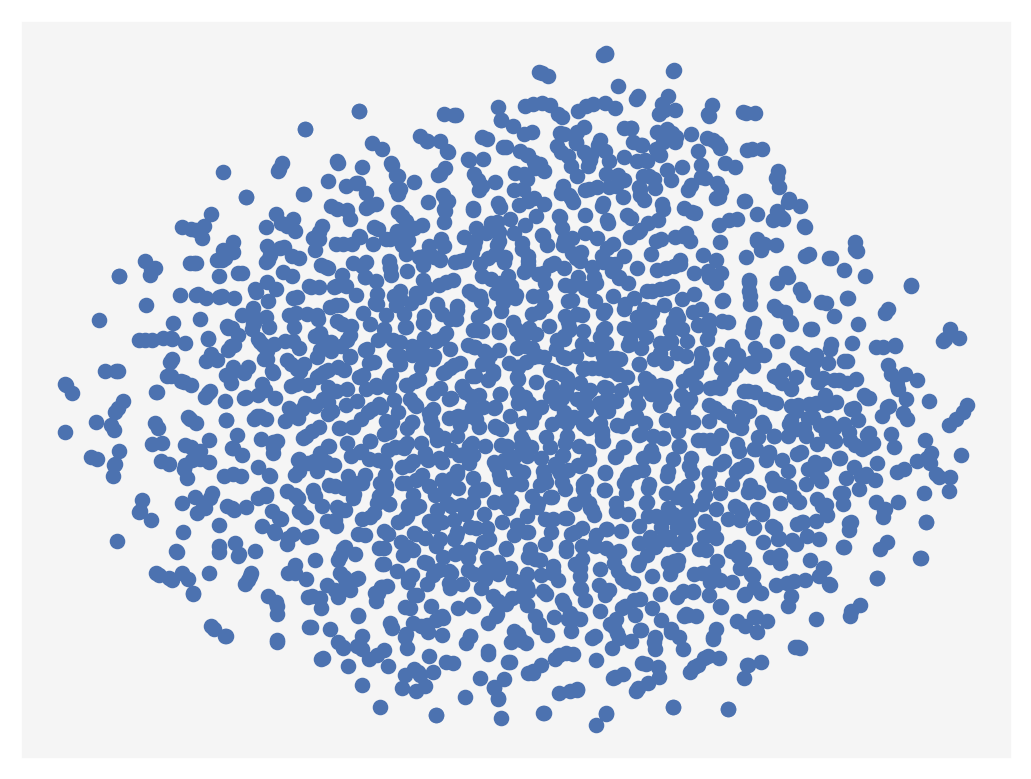

In [3]:
run(1, 20)

epoch: 1, ELBO: 33.7374, MSE: 18.1669, KLD: 15.5706
epoch: 2, ELBO: 25.3728, MSE: 12.4529, KLD: 12.9199
epoch: 3, ELBO: 20.6299, MSE: 8.0752, KLD: 12.5547
epoch: 4, ELBO: 26.6711, MSE: 15.1144, KLD: 11.5567
epoch: 5, ELBO: 17.4416, MSE: 7.0696, KLD: 10.3720
epoch: 6, ELBO: 16.6268, MSE: 6.7768, KLD: 9.8500
epoch: 7, ELBO: 15.8619, MSE: 6.4405, KLD: 9.4213
epoch: 8, ELBO: 15.9839, MSE: 7.1168, KLD: 8.8671
epoch: 9, ELBO: 16.2501, MSE: 7.9554, KLD: 8.2948
epoch: 10, ELBO: 14.7238, MSE: 6.8299, KLD: 7.8940
epoch: 11, ELBO: 14.7468, MSE: 7.7622, KLD: 6.9846
epoch: 12, ELBO: 14.2146, MSE: 6.9366, KLD: 7.2780
epoch: 13, ELBO: 13.8647, MSE: 7.0825, KLD: 6.7822
epoch: 14, ELBO: 11.0650, MSE: 4.1902, KLD: 6.8748
epoch: 15, ELBO: 11.1673, MSE: 4.4470, KLD: 6.7202
epoch: 16, ELBO: 11.3623, MSE: 4.6627, KLD: 6.6995
epoch: 17, ELBO: 11.5573, MSE: 5.5567, KLD: 6.0006
epoch: 18, ELBO: 10.9846, MSE: 4.3733, KLD: 6.6113
epoch: 19, ELBO: 9.9000, MSE: 3.0523, KLD: 6.8478
epoch: 20, ELBO: 9.8578, MSE: 3.5

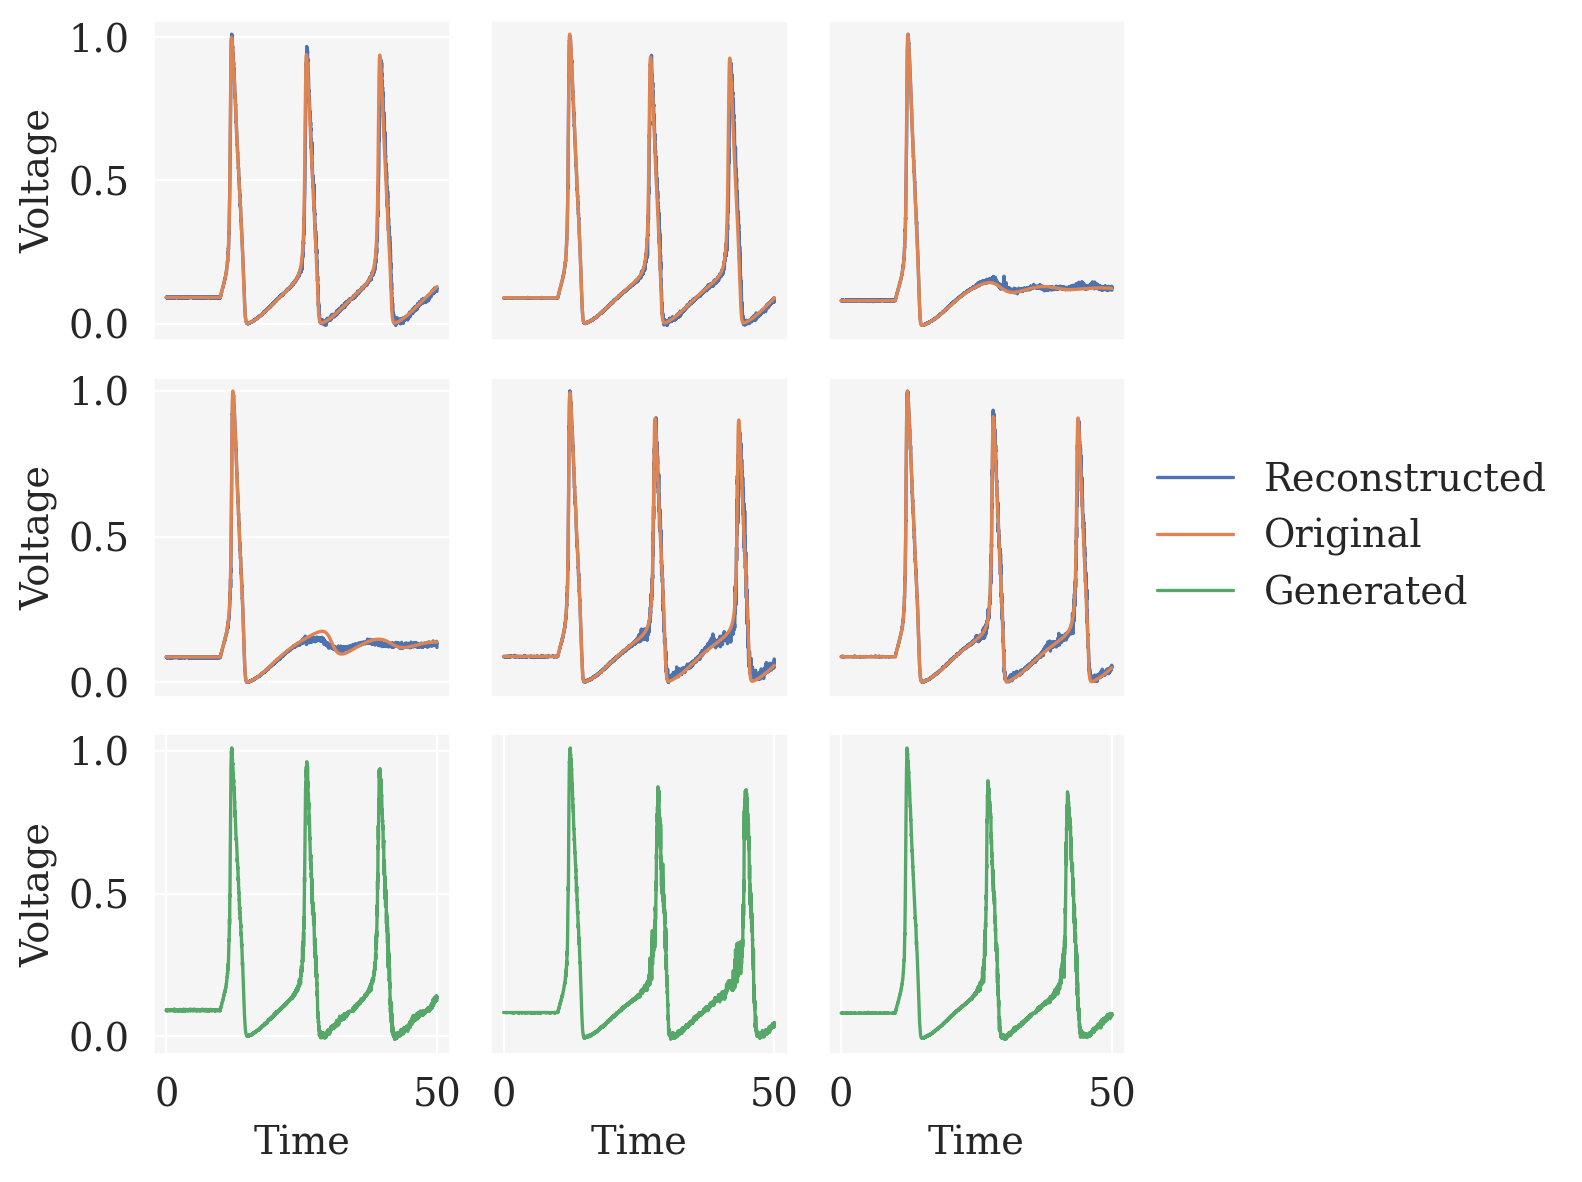

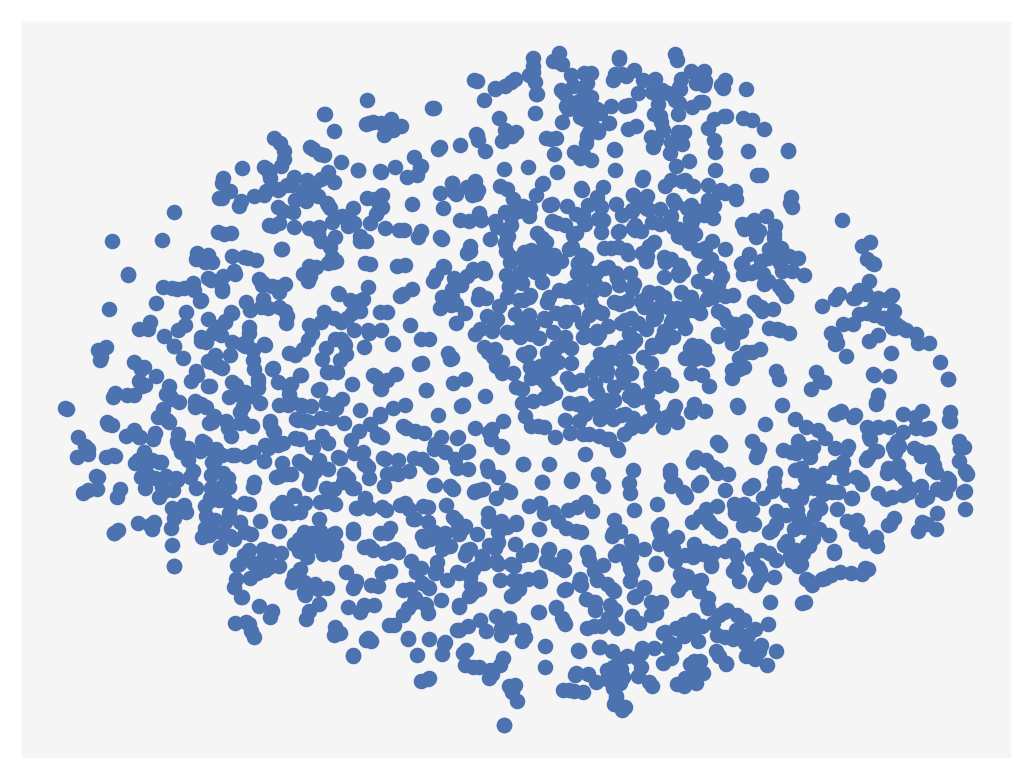

In [4]:
run(1, 10)

epoch: 1, ELBO: 30.9440, MSE: 24.1064, KLD: 6.8377
epoch: 2, ELBO: 21.0594, MSE: 15.4183, KLD: 5.6411
epoch: 3, ELBO: 14.6709, MSE: 9.1297, KLD: 5.5412
epoch: 4, ELBO: 13.7871, MSE: 7.9248, KLD: 5.8623
epoch: 5, ELBO: 18.7472, MSE: 13.4620, KLD: 5.2852
epoch: 6, ELBO: 11.6964, MSE: 6.3980, KLD: 5.2984
epoch: 7, ELBO: 13.8071, MSE: 8.9414, KLD: 4.8657
epoch: 8, ELBO: 9.7896, MSE: 4.1228, KLD: 5.6668
epoch: 9, ELBO: 9.8487, MSE: 4.6259, KLD: 5.2228
epoch: 10, ELBO: 10.7306, MSE: 5.7461, KLD: 4.9845
epoch: 11, ELBO: 9.1495, MSE: 3.8297, KLD: 5.3197
epoch: 12, ELBO: 10.3436, MSE: 4.7707, KLD: 5.5728
epoch: 13, ELBO: 9.0808, MSE: 3.6402, KLD: 5.4406
epoch: 14, ELBO: 9.3921, MSE: 4.0776, KLD: 5.3145
epoch: 15, ELBO: 10.0369, MSE: 4.5205, KLD: 5.5164
epoch: 16, ELBO: 10.6516, MSE: 5.7571, KLD: 4.8944
epoch: 17, ELBO: 8.6668, MSE: 3.2182, KLD: 5.4487
epoch: 18, ELBO: 10.6812, MSE: 5.5437, KLD: 5.1375
epoch: 19, ELBO: 8.9461, MSE: 3.0015, KLD: 5.9445
epoch: 20, ELBO: 10.2861, MSE: 5.7929, KLD: 

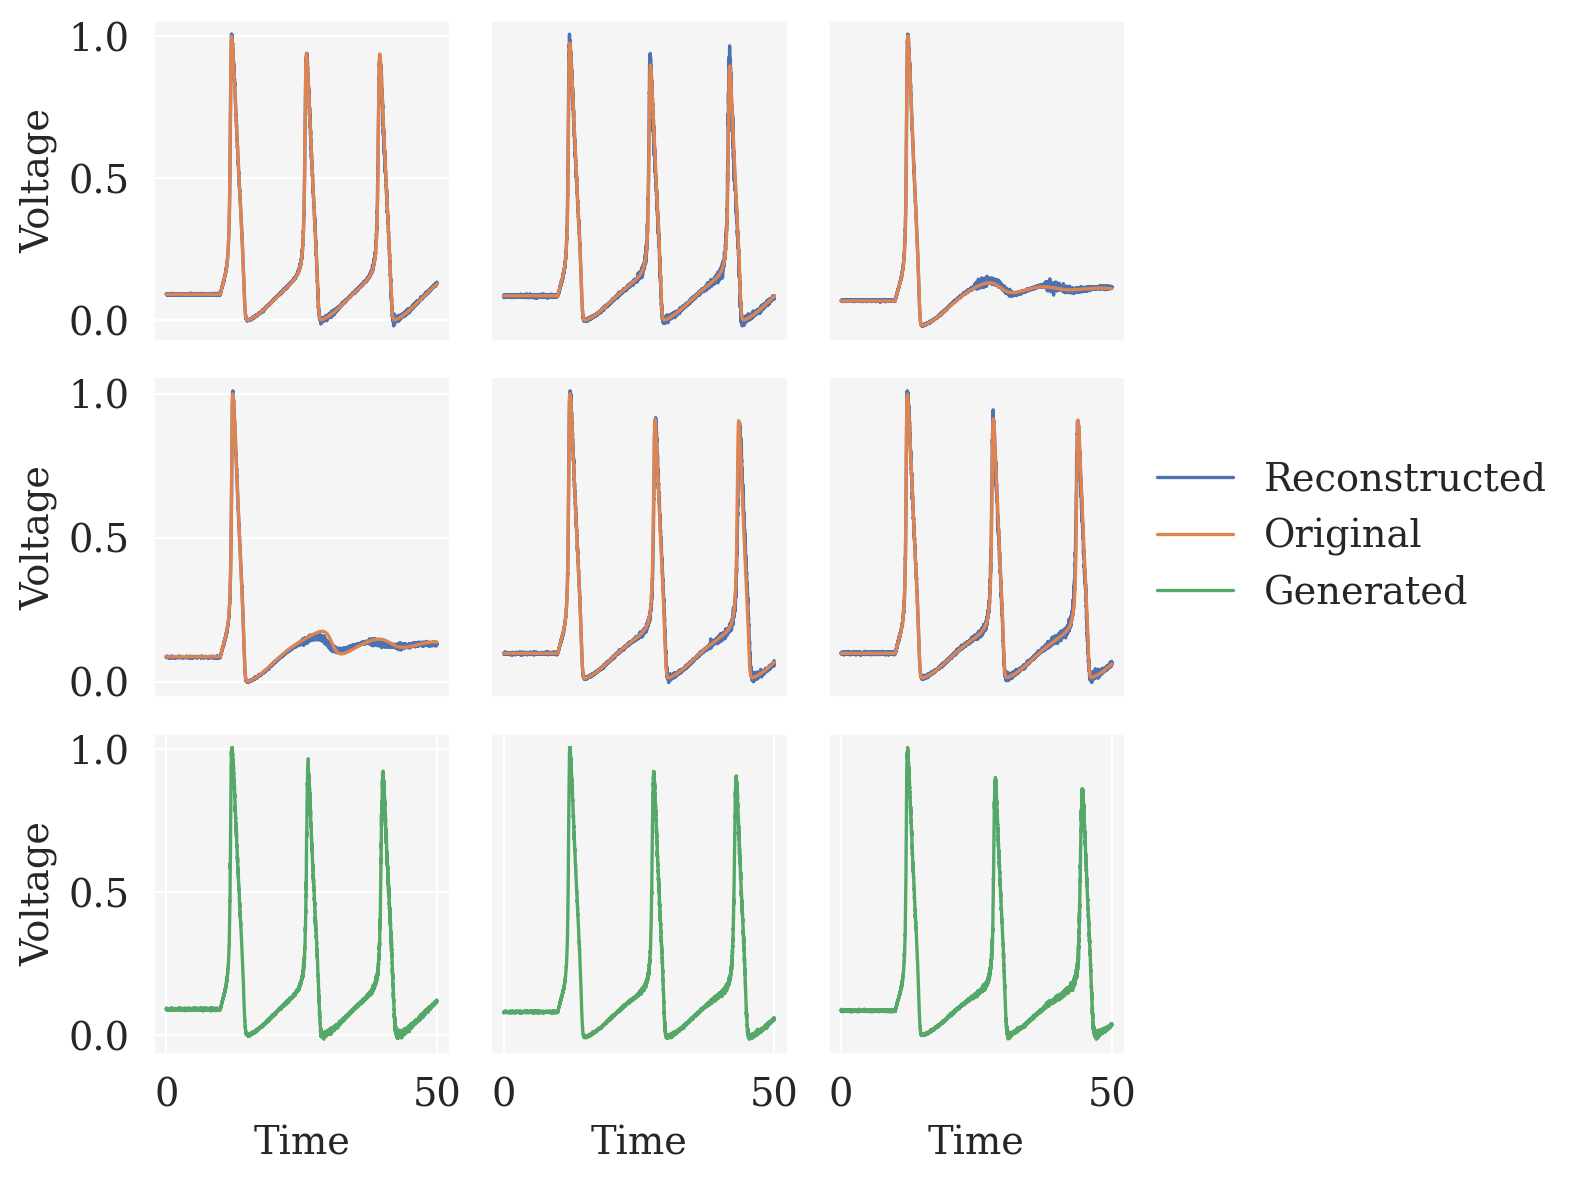

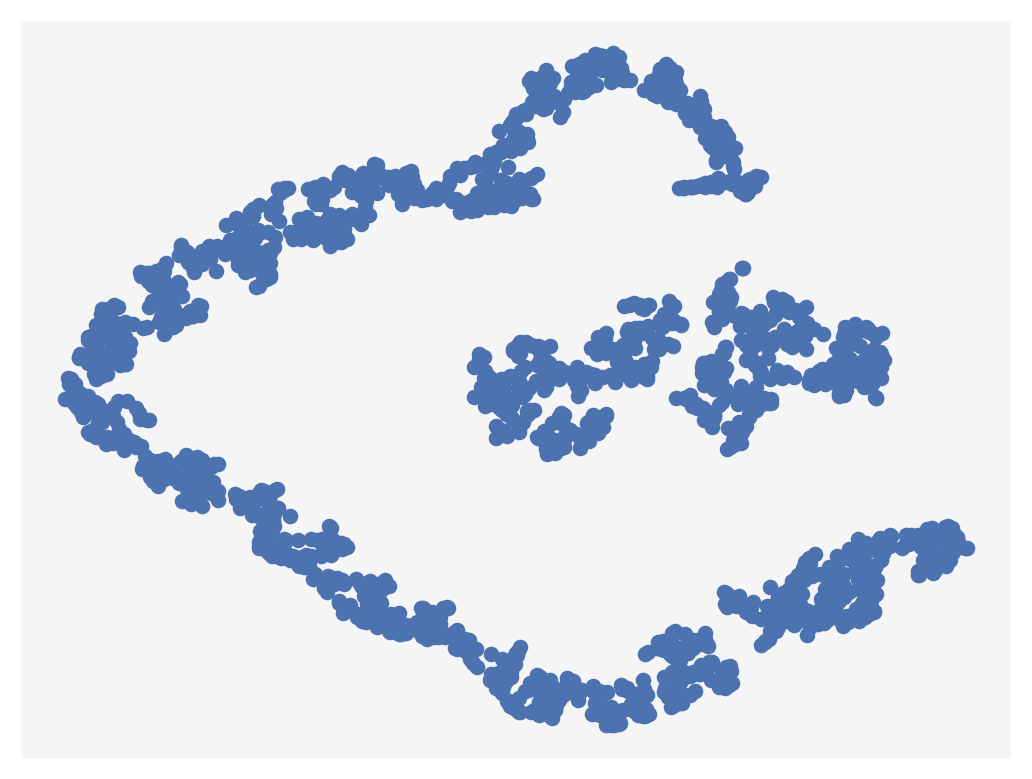

In [5]:
run(1, 2)

epoch: 1, ELBO: 29.2999, MSE: 16.2334, KLD: 26.1329
epoch: 2, ELBO: 20.8699, MSE: 8.9307, KLD: 23.8784
epoch: 3, ELBO: 17.7213, MSE: 7.8831, KLD: 19.6763
epoch: 4, ELBO: 17.1701, MSE: 8.2185, KLD: 17.9032
epoch: 5, ELBO: 15.2094, MSE: 6.8834, KLD: 16.6521
epoch: 6, ELBO: 12.7457, MSE: 4.8350, KLD: 15.8215
epoch: 7, ELBO: 11.3683, MSE: 4.4957, KLD: 13.7452
epoch: 8, ELBO: 11.5194, MSE: 5.3318, KLD: 12.3751
epoch: 9, ELBO: 9.8307, MSE: 3.8861, KLD: 11.8891
epoch: 10, ELBO: 9.4365, MSE: 4.1045, KLD: 10.6640
epoch: 11, ELBO: 8.5060, MSE: 3.2372, KLD: 10.5375
epoch: 12, ELBO: 8.8873, MSE: 3.5964, KLD: 10.5819
epoch: 13, ELBO: 8.3031, MSE: 3.5533, KLD: 9.4995
epoch: 14, ELBO: 7.6541, MSE: 3.2348, KLD: 8.8385
epoch: 15, ELBO: 7.7144, MSE: 3.1195, KLD: 9.1898
epoch: 16, ELBO: 7.3449, MSE: 2.7288, KLD: 9.2322
epoch: 17, ELBO: 8.2938, MSE: 3.9785, KLD: 8.6306
epoch: 18, ELBO: 7.4151, MSE: 3.5339, KLD: 7.7623
epoch: 19, ELBO: 7.4714, MSE: 3.5637, KLD: 7.8155
epoch: 20, ELBO: 6.2603, MSE: 2.5111, 

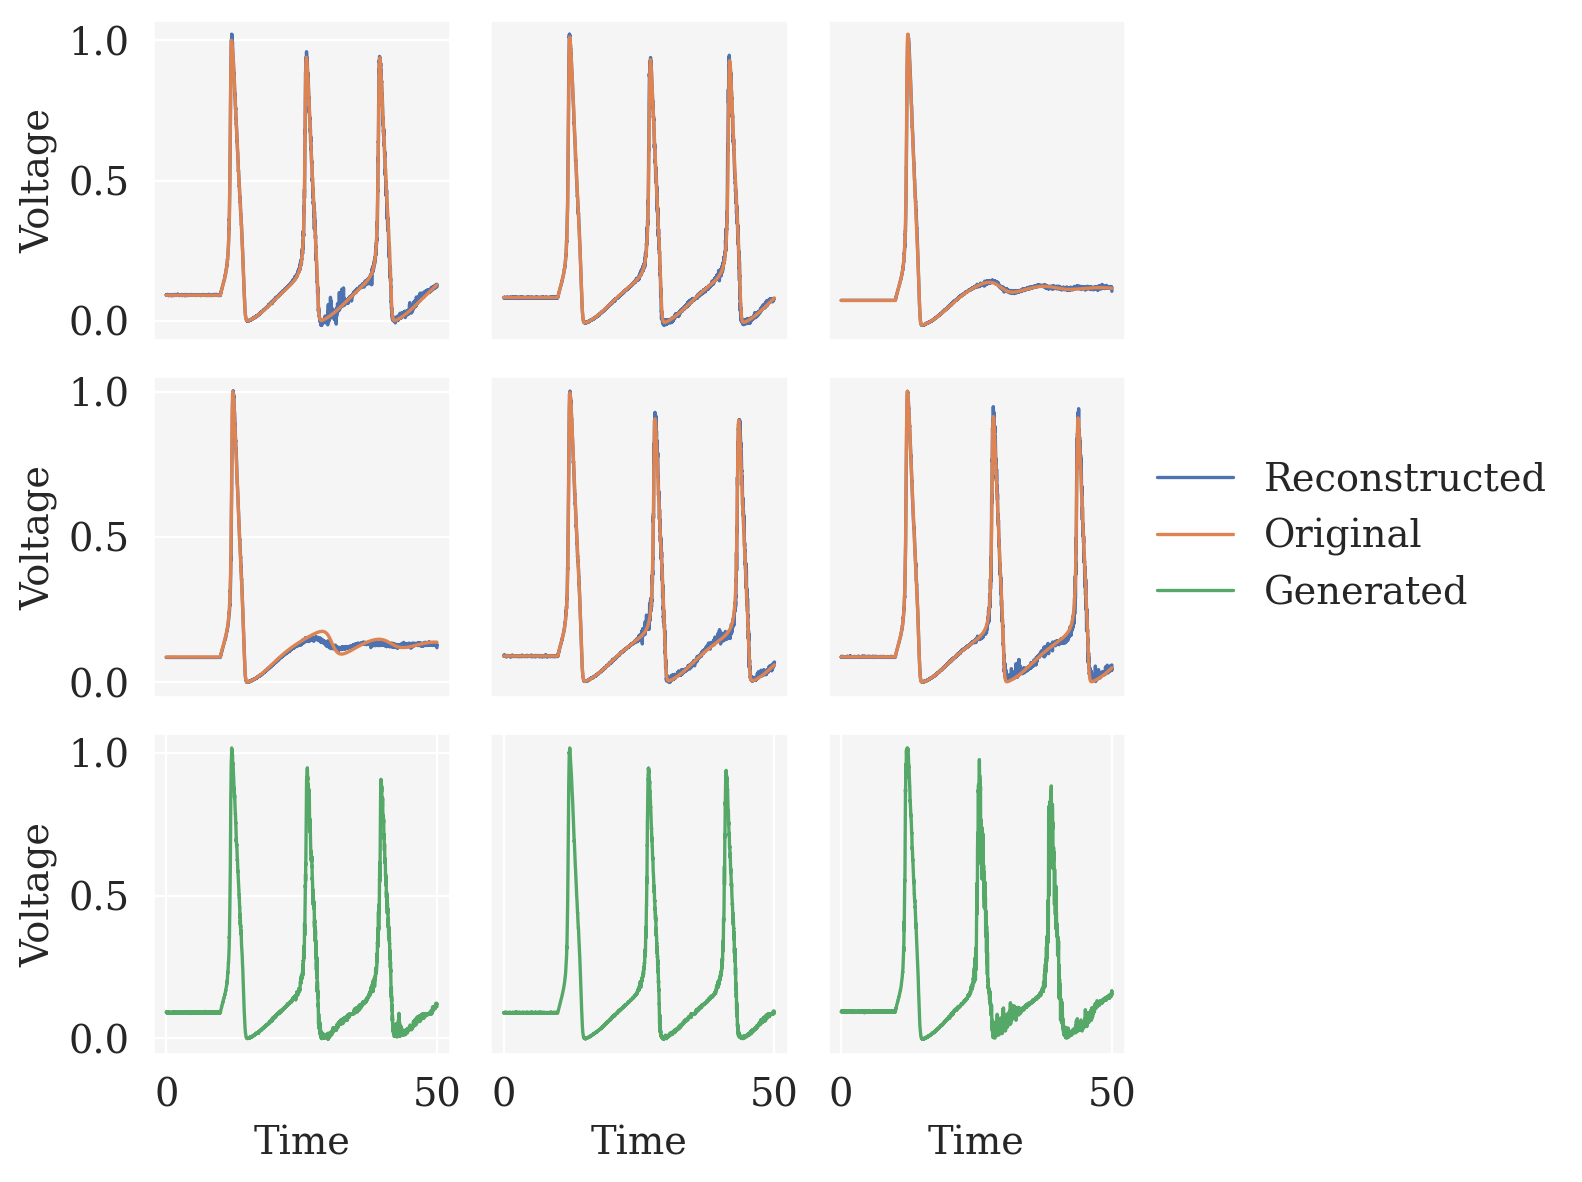

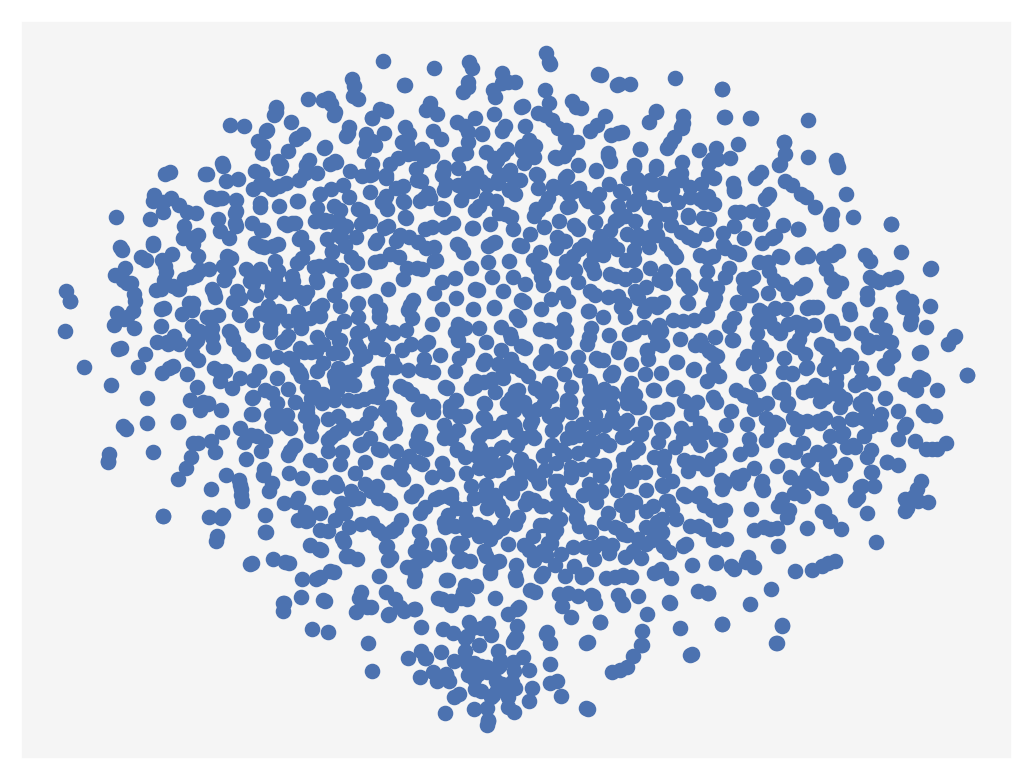

In [6]:
run(0.5, 20)

epoch: 1, ELBO: 23.9199, MSE: 13.0335, KLD: 21.7729
epoch: 2, ELBO: 17.8403, MSE: 8.4066, KLD: 18.8674
epoch: 3, ELBO: 16.0926, MSE: 7.5276, KLD: 17.1300
epoch: 4, ELBO: 13.5302, MSE: 5.4750, KLD: 16.1103
epoch: 5, ELBO: 13.4107, MSE: 5.7292, KLD: 15.3630
epoch: 6, ELBO: 11.5376, MSE: 4.0055, KLD: 15.0643
epoch: 7, ELBO: 12.6566, MSE: 5.7620, KLD: 13.7891
epoch: 8, ELBO: 10.6083, MSE: 4.5756, KLD: 12.0654
epoch: 9, ELBO: 9.4057, MSE: 3.4475, KLD: 11.9166
epoch: 10, ELBO: 9.3077, MSE: 3.3217, KLD: 11.9721
epoch: 11, ELBO: 9.4512, MSE: 4.2948, KLD: 10.3128
epoch: 12, ELBO: 8.6942, MSE: 3.1904, KLD: 11.0077
epoch: 13, ELBO: 8.0485, MSE: 3.0497, KLD: 9.9976
epoch: 14, ELBO: 7.9969, MSE: 3.1382, KLD: 9.7173
epoch: 15, ELBO: 8.2415, MSE: 3.3694, KLD: 9.7443
epoch: 16, ELBO: 7.4861, MSE: 2.7209, KLD: 9.5304
epoch: 17, ELBO: 6.9465, MSE: 2.5477, KLD: 8.7976
epoch: 18, ELBO: 8.0170, MSE: 3.2457, KLD: 9.5425
epoch: 19, ELBO: 6.5671, MSE: 2.4249, KLD: 8.2843
epoch: 20, ELBO: 7.0653, MSE: 2.7952, 

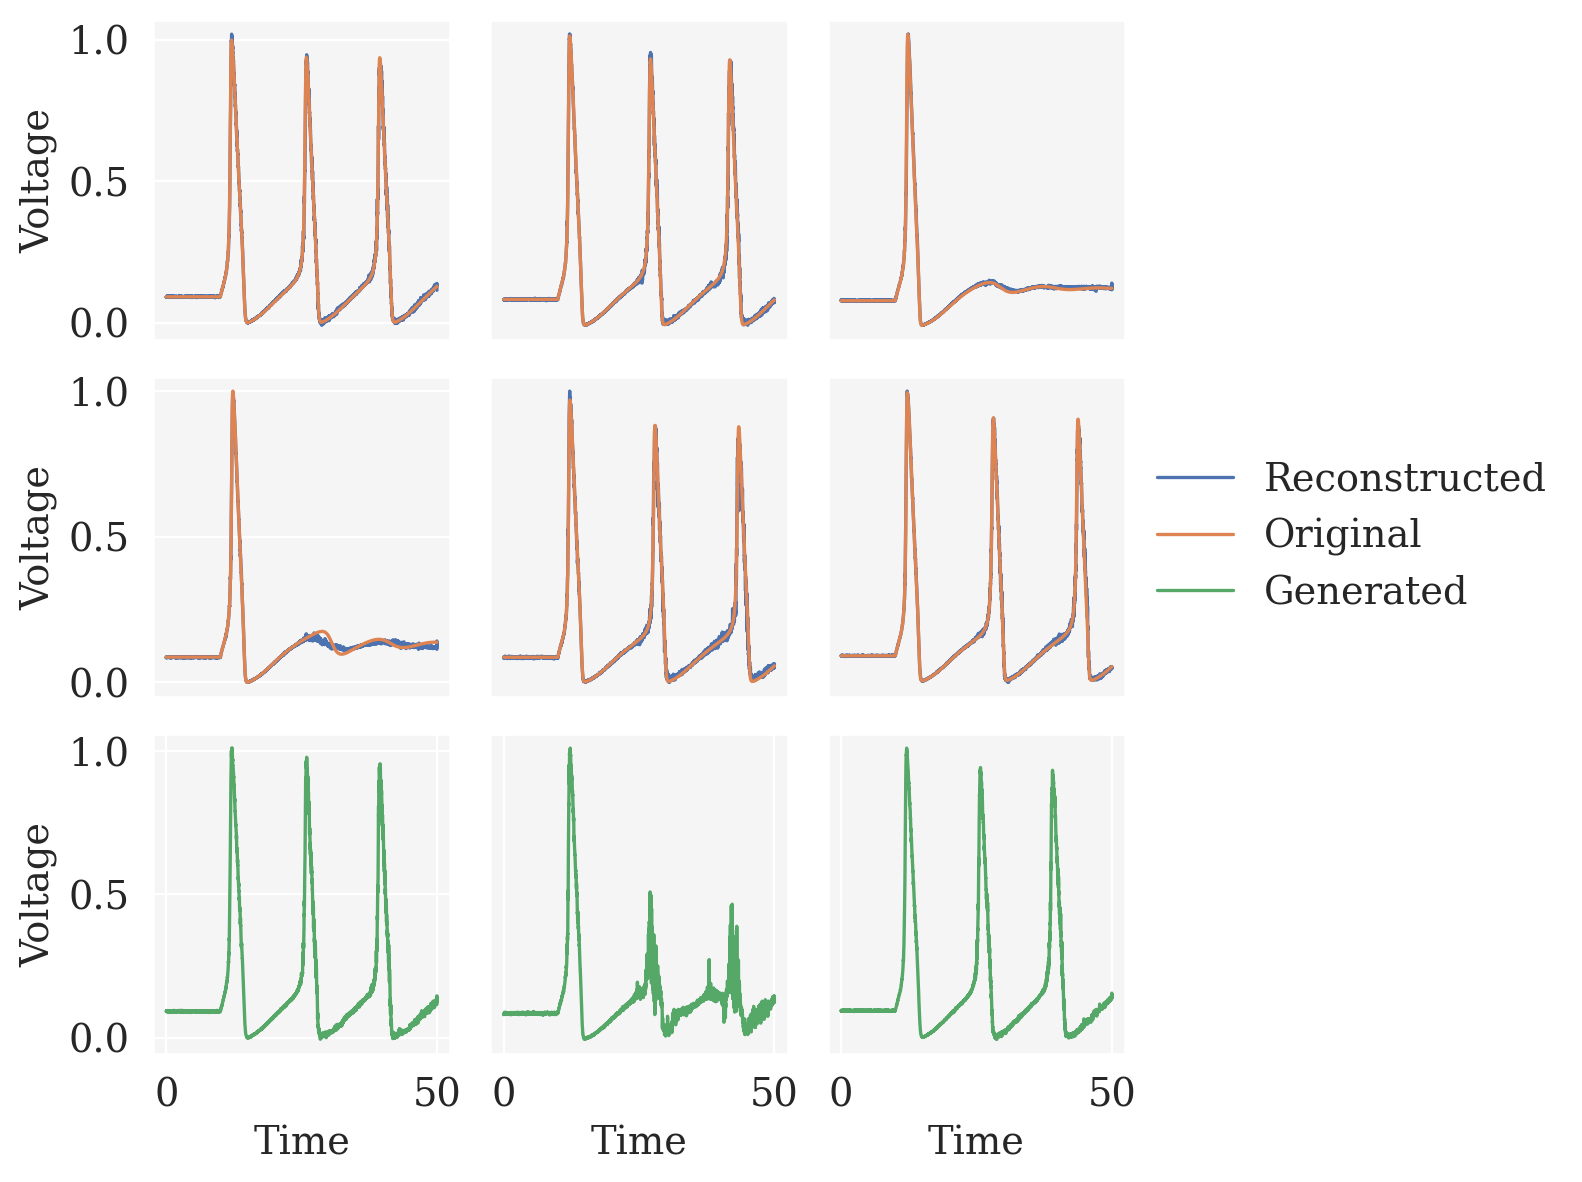

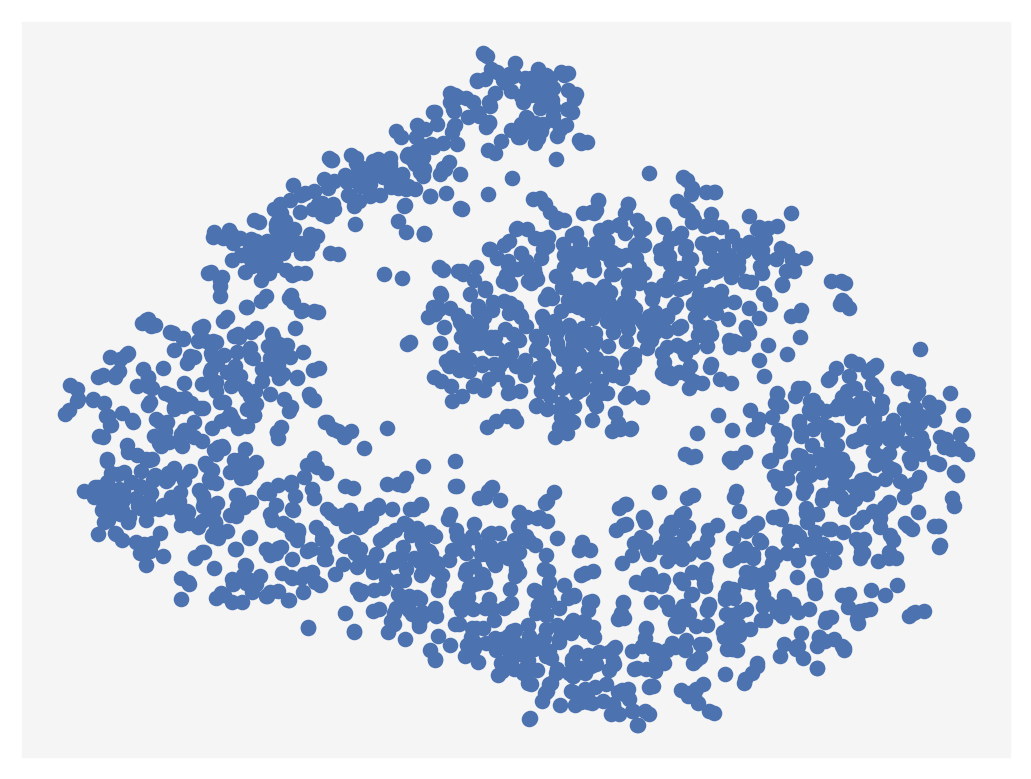

In [7]:
run(0.5, 10)

epoch: 1, ELBO: 39.1874, MSE: 35.5038, KLD: 7.3673
epoch: 2, ELBO: 14.0034, MSE: 10.6583, KLD: 6.6902
epoch: 3, ELBO: 13.6443, MSE: 10.3084, KLD: 6.6717
epoch: 4, ELBO: 8.7922, MSE: 5.3913, KLD: 6.8018
epoch: 5, ELBO: 14.2682, MSE: 10.8590, KLD: 6.8183
epoch: 6, ELBO: 8.1373, MSE: 5.0918, KLD: 6.0910
epoch: 7, ELBO: 10.7919, MSE: 7.6568, KLD: 6.2703
epoch: 8, ELBO: 12.3033, MSE: 9.1720, KLD: 6.2626
epoch: 9, ELBO: 11.6072, MSE: 8.2375, KLD: 6.7393
epoch: 10, ELBO: 8.5266, MSE: 5.5704, KLD: 5.9124
epoch: 11, ELBO: 8.3586, MSE: 5.4580, KLD: 5.8012
epoch: 12, ELBO: 7.0323, MSE: 3.9121, KLD: 6.2405
epoch: 13, ELBO: 9.8646, MSE: 6.9405, KLD: 5.8482
epoch: 14, ELBO: 9.5288, MSE: 6.7822, KLD: 5.4933
epoch: 15, ELBO: 9.0653, MSE: 6.3129, KLD: 5.5049
epoch: 16, ELBO: 6.8599, MSE: 3.9346, KLD: 5.8506
epoch: 17, ELBO: 7.3532, MSE: 4.3928, KLD: 5.9209
epoch: 18, ELBO: 8.8211, MSE: 5.8030, KLD: 6.0363
epoch: 19, ELBO: 6.8791, MSE: 4.1164, KLD: 5.5255
epoch: 20, ELBO: 8.2303, MSE: 5.5133, KLD: 5.434

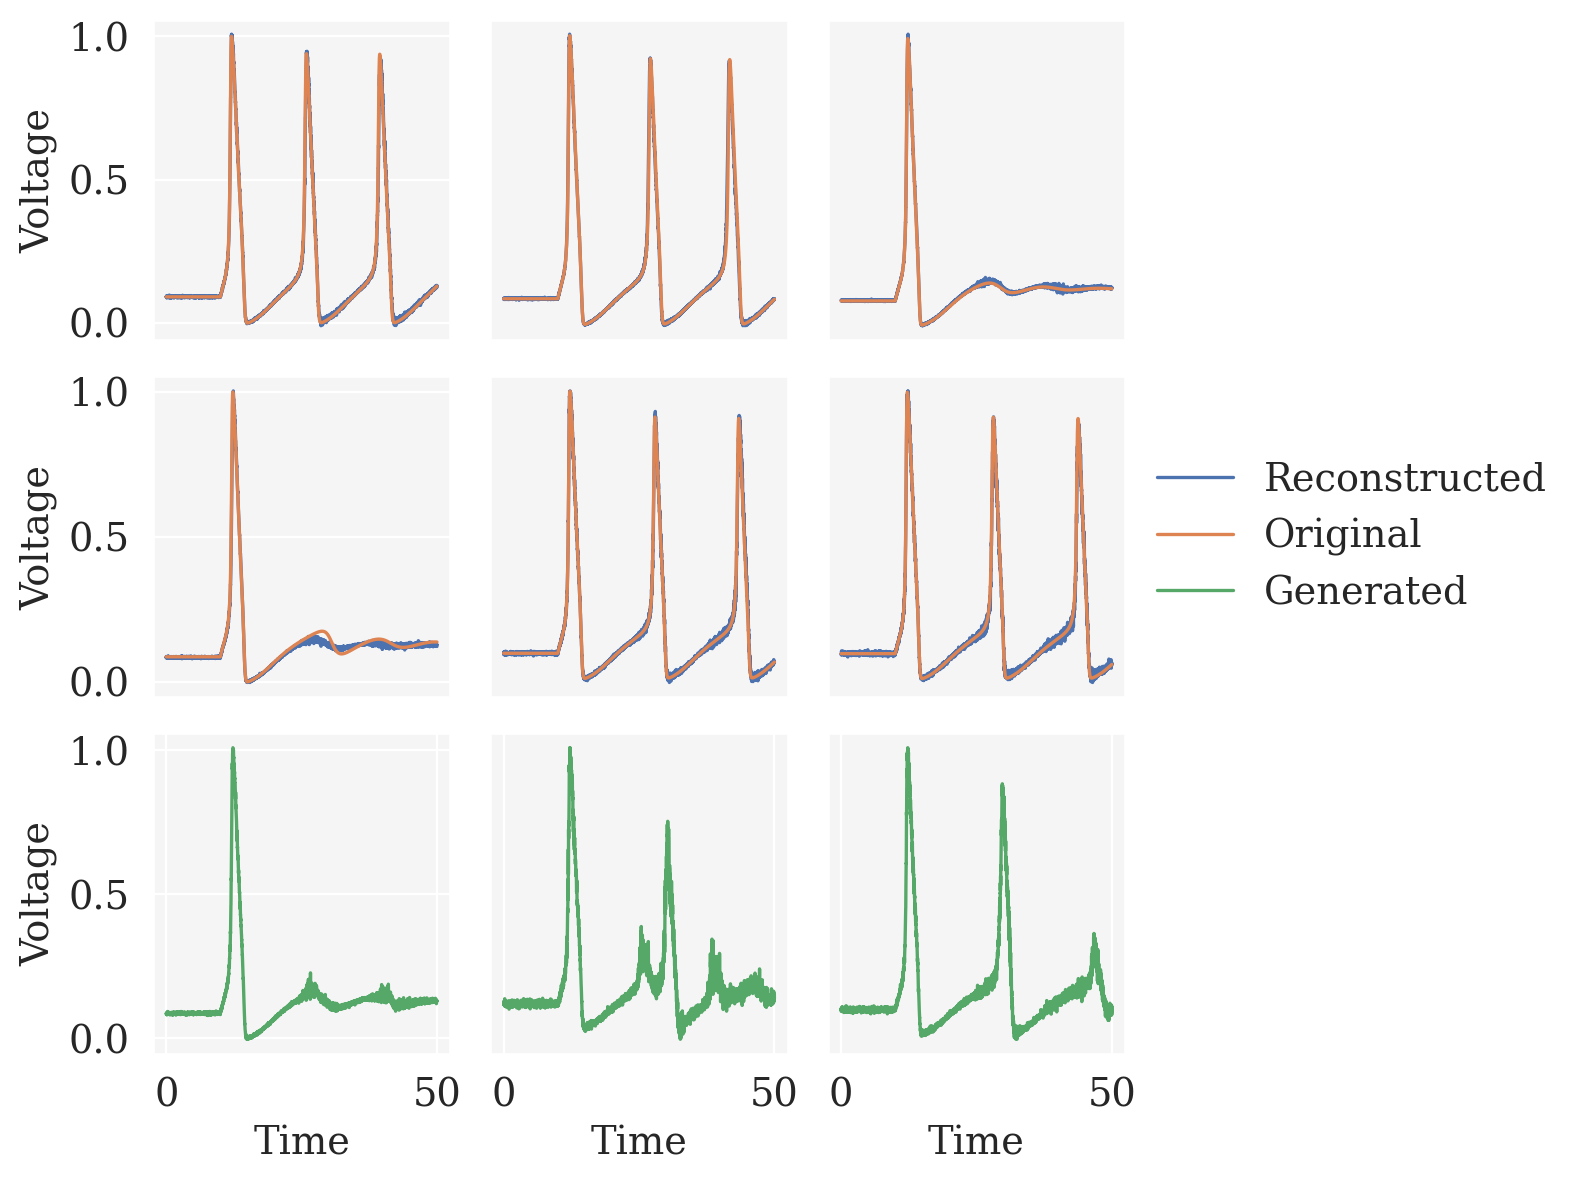

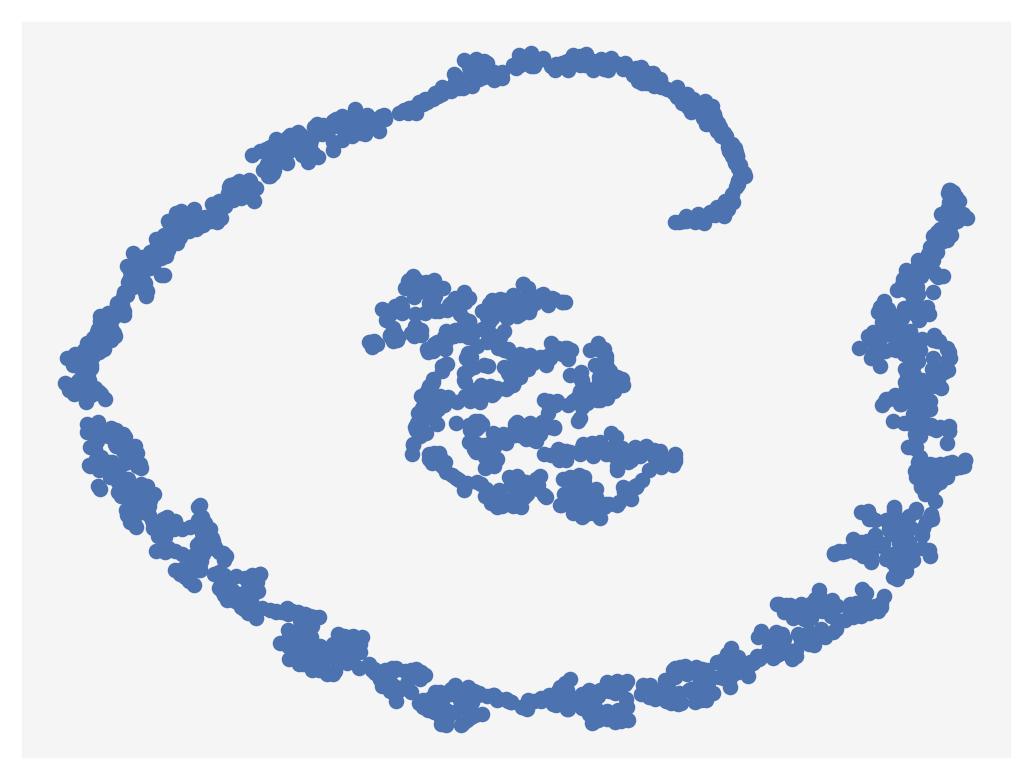

In [8]:
run(0.5, 2)

epoch: 1, ELBO: 81.5391, MSE: 70.0020, KLD: 5.7685
epoch: 2, ELBO: 65.9258, MSE: 58.8359, KLD: 3.5450
epoch: 3, ELBO: 57.8577, MSE: 49.4473, KLD: 4.2052
epoch: 4, ELBO: 52.4210, MSE: 44.2800, KLD: 4.0705
epoch: 5, ELBO: 43.5686, MSE: 34.1192, KLD: 4.7247
epoch: 6, ELBO: 40.7158, MSE: 31.7511, KLD: 4.4824
epoch: 7, ELBO: 40.4001, MSE: 31.9213, KLD: 4.2394
epoch: 8, ELBO: 34.0574, MSE: 25.5524, KLD: 4.2525
epoch: 9, ELBO: 31.3755, MSE: 22.8573, KLD: 4.2591
epoch: 10, ELBO: 33.1719, MSE: 25.8921, KLD: 3.6399
epoch: 11, ELBO: 32.3294, MSE: 24.6643, KLD: 3.8326
epoch: 12, ELBO: 27.4706, MSE: 19.4853, KLD: 3.9926
epoch: 13, ELBO: 24.9206, MSE: 15.9771, KLD: 4.4717
epoch: 14, ELBO: 25.5252, MSE: 17.3124, KLD: 4.1064
epoch: 15, ELBO: 26.0663, MSE: 18.3140, KLD: 3.8761
epoch: 16, ELBO: 22.8727, MSE: 15.3682, KLD: 3.7523
epoch: 17, ELBO: 25.5617, MSE: 17.4088, KLD: 4.0765
epoch: 18, ELBO: 23.0878, MSE: 15.2872, KLD: 3.9003
epoch: 19, ELBO: 22.7072, MSE: 15.2733, KLD: 3.7169
epoch: 20, ELBO: 27.6

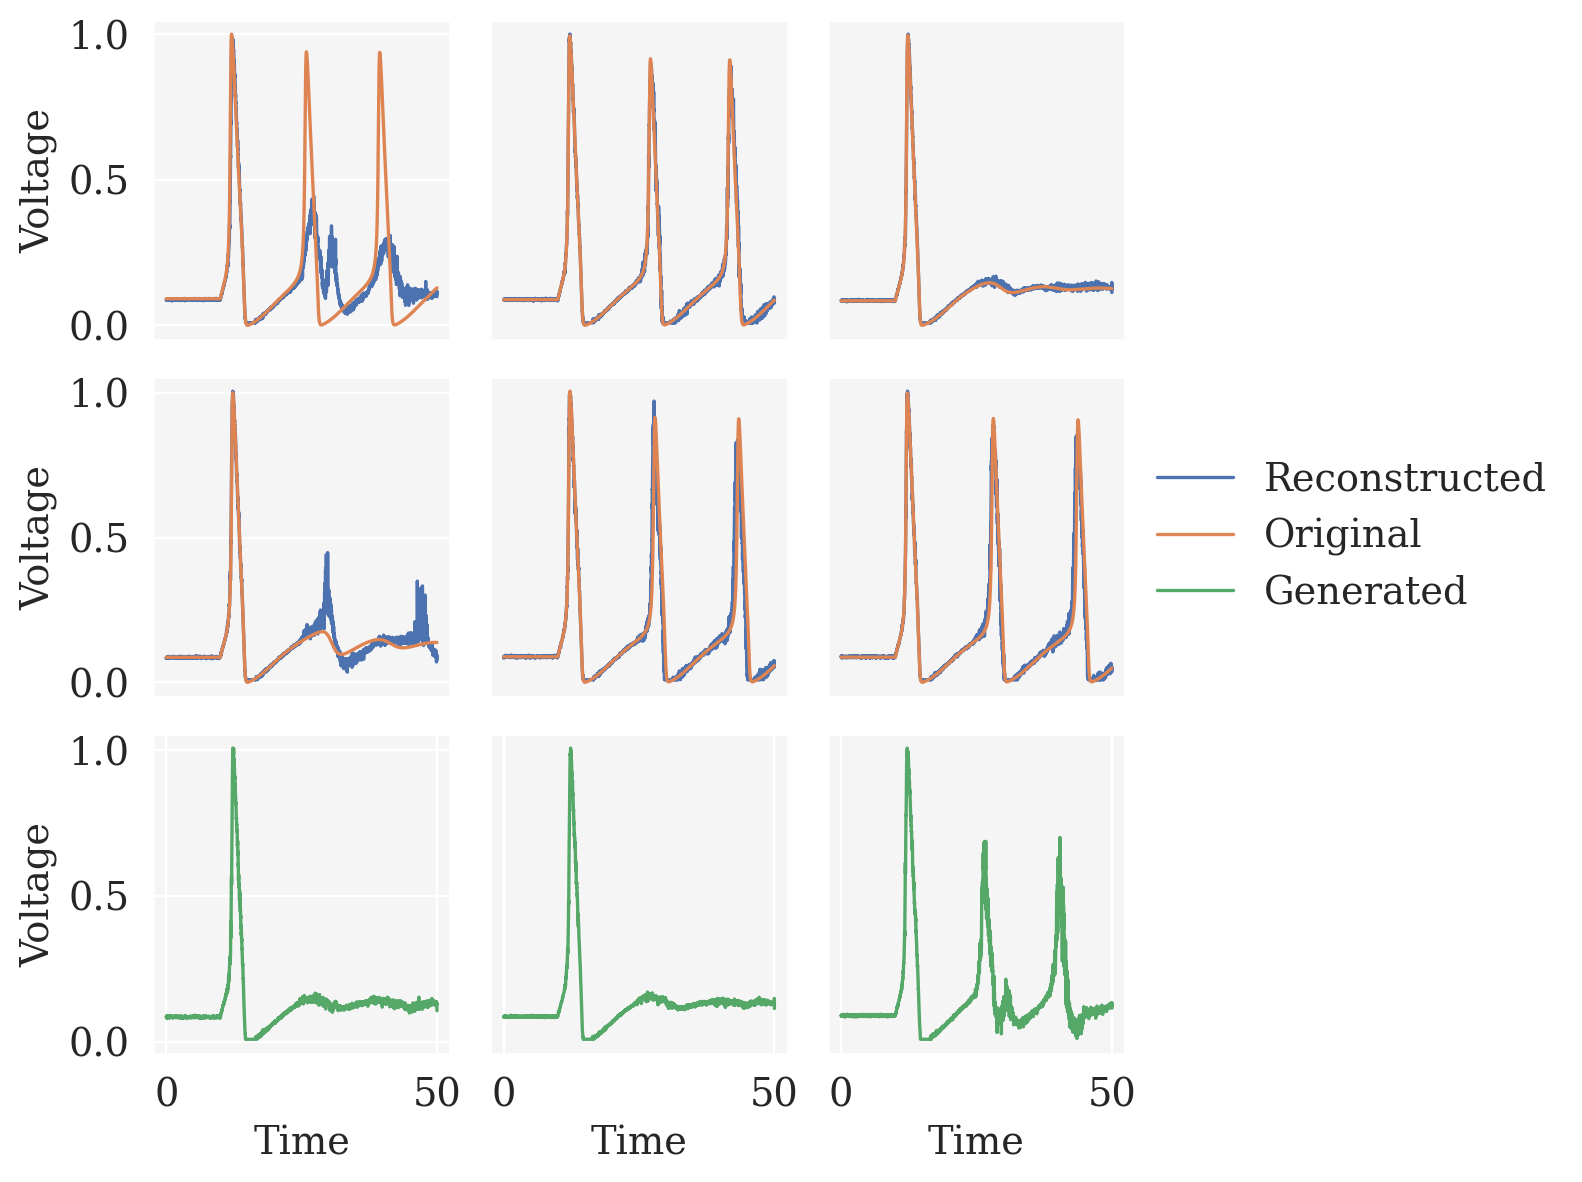

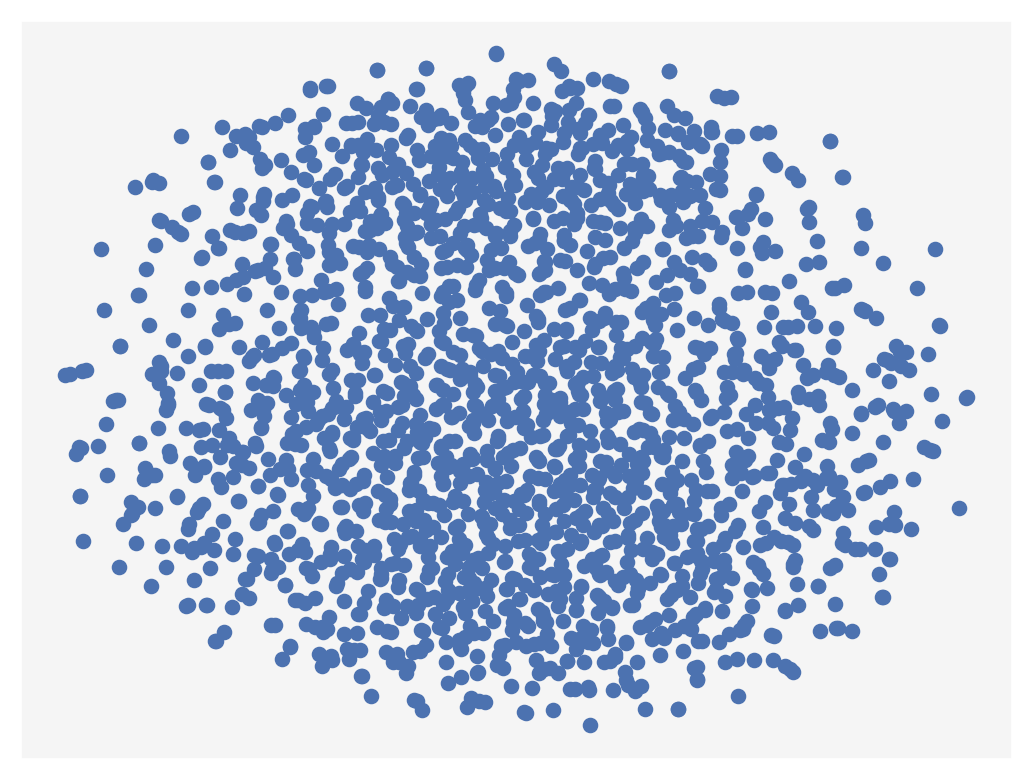

In [9]:
run(2, 20)

epoch: 1, ELBO: 46.4318, MSE: 24.7256, KLD: 10.8531
epoch: 2, ELBO: 35.2828, MSE: 20.7070, KLD: 7.2879
epoch: 3, ELBO: 31.6537, MSE: 16.8107, KLD: 7.4215
epoch: 4, ELBO: 26.6163, MSE: 13.3088, KLD: 6.6538
epoch: 5, ELBO: 23.5174, MSE: 11.6640, KLD: 5.9267
epoch: 6, ELBO: 21.1987, MSE: 10.1248, KLD: 5.5370
epoch: 7, ELBO: 19.0350, MSE: 9.1873, KLD: 4.9239
epoch: 8, ELBO: 18.7083, MSE: 9.6519, KLD: 4.5282
epoch: 9, ELBO: 17.7571, MSE: 8.6021, KLD: 4.5775
epoch: 10, ELBO: 16.0520, MSE: 6.5663, KLD: 4.7428
epoch: 11, ELBO: 15.6396, MSE: 7.2042, KLD: 4.2177
epoch: 12, ELBO: 15.0639, MSE: 6.1767, KLD: 4.4436
epoch: 13, ELBO: 15.6141, MSE: 7.4851, KLD: 4.0645
epoch: 14, ELBO: 14.2654, MSE: 5.1581, KLD: 4.5536
epoch: 15, ELBO: 14.3683, MSE: 5.8863, KLD: 4.2410
epoch: 16, ELBO: 15.0066, MSE: 6.8279, KLD: 4.0894
epoch: 17, ELBO: 15.2233, MSE: 7.0336, KLD: 4.0948
epoch: 18, ELBO: 15.5561, MSE: 7.4732, KLD: 4.0415
epoch: 19, ELBO: 13.3111, MSE: 5.1729, KLD: 4.0691
epoch: 20, ELBO: 15.8373, MSE: 7.

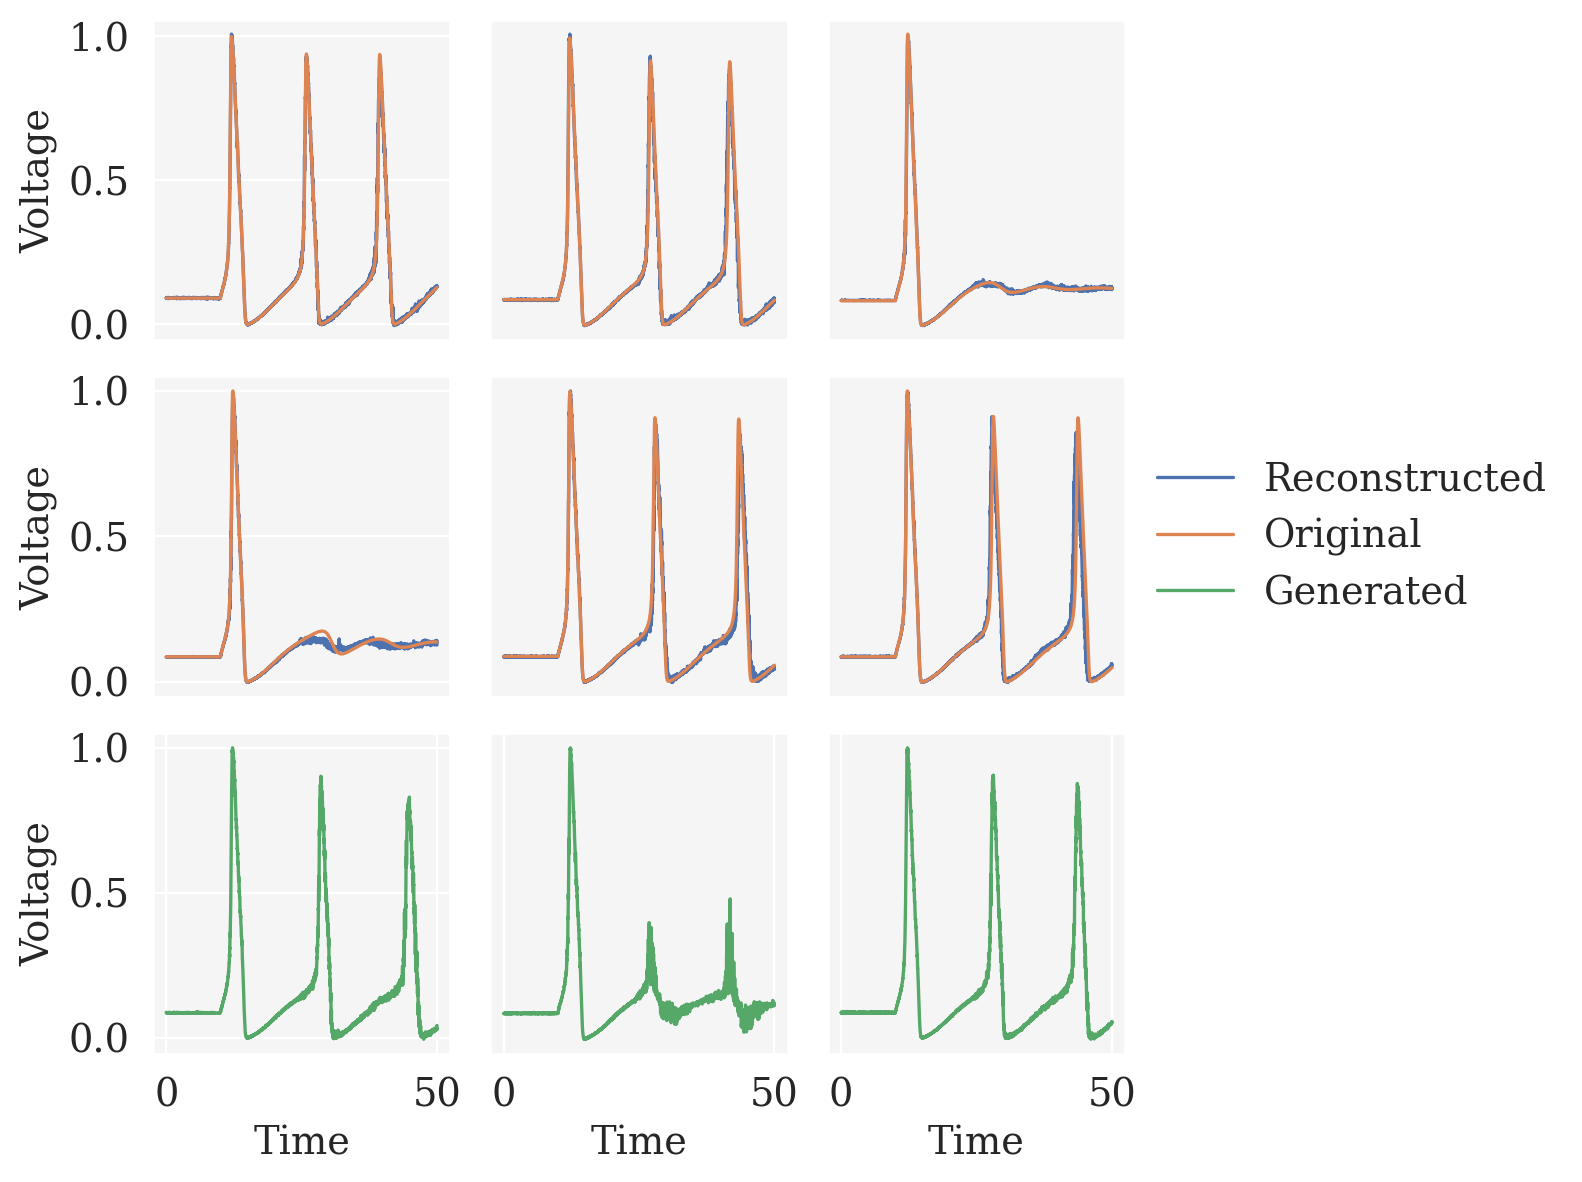

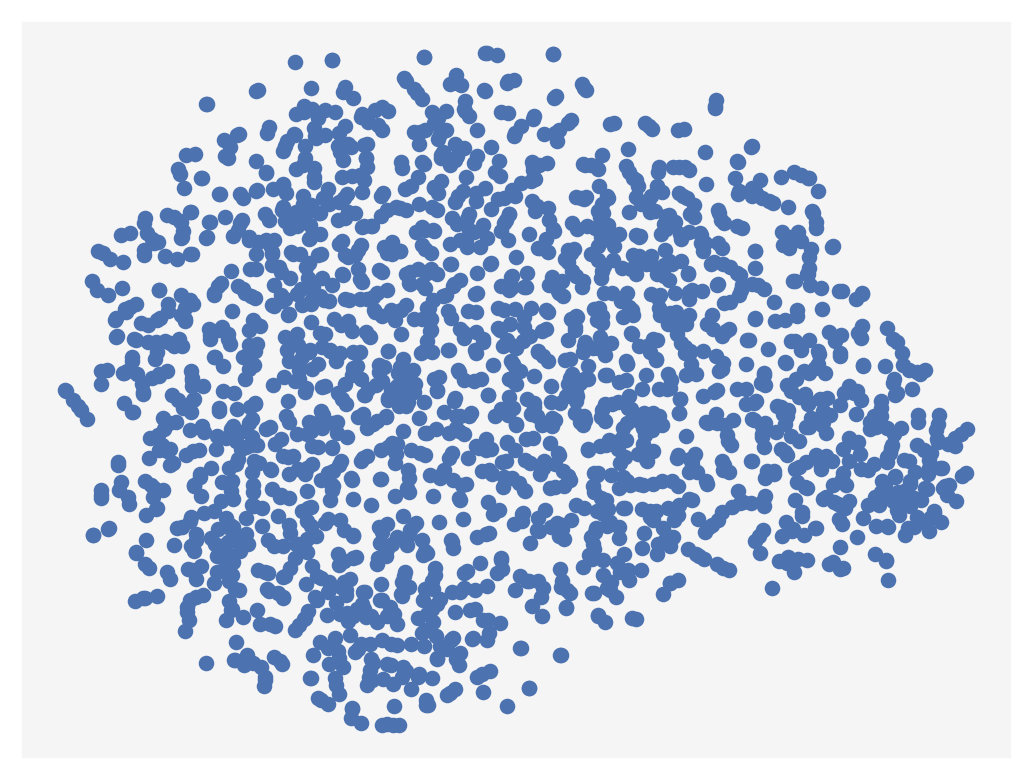

In [10]:
run(2, 10)

epoch: 1, ELBO: 28.9951, MSE: 18.7383, KLD: 5.1284
epoch: 2, ELBO: 28.0405, MSE: 18.3666, KLD: 4.8370
epoch: 3, ELBO: 17.7394, MSE: 9.1465, KLD: 4.2964
epoch: 4, ELBO: 18.7855, MSE: 10.2189, KLD: 4.2833
epoch: 5, ELBO: 14.9685, MSE: 6.1559, KLD: 4.4063
epoch: 6, ELBO: 15.4220, MSE: 7.1644, KLD: 4.1288
epoch: 7, ELBO: 15.4953, MSE: 7.2129, KLD: 4.1412
epoch: 8, ELBO: 13.7901, MSE: 4.7964, KLD: 4.4969
epoch: 9, ELBO: 14.5891, MSE: 6.9781, KLD: 3.8055
epoch: 10, ELBO: 14.1944, MSE: 6.4203, KLD: 3.8870
epoch: 11, ELBO: 15.1479, MSE: 7.5181, KLD: 3.8149
epoch: 12, ELBO: 16.4234, MSE: 8.8269, KLD: 3.7982
epoch: 13, ELBO: 17.3094, MSE: 8.8725, KLD: 4.2185
epoch: 14, ELBO: 15.5476, MSE: 6.8876, KLD: 4.3300
epoch: 15, ELBO: 13.8146, MSE: 5.0417, KLD: 4.3865
epoch: 16, ELBO: 16.4285, MSE: 6.8571, KLD: 4.7857
epoch: 17, ELBO: 19.4756, MSE: 11.5392, KLD: 3.9682
epoch: 18, ELBO: 15.8944, MSE: 7.2942, KLD: 4.3001
epoch: 19, ELBO: 14.3538, MSE: 5.9844, KLD: 4.1847
epoch: 20, ELBO: 21.5583, MSE: 14.04

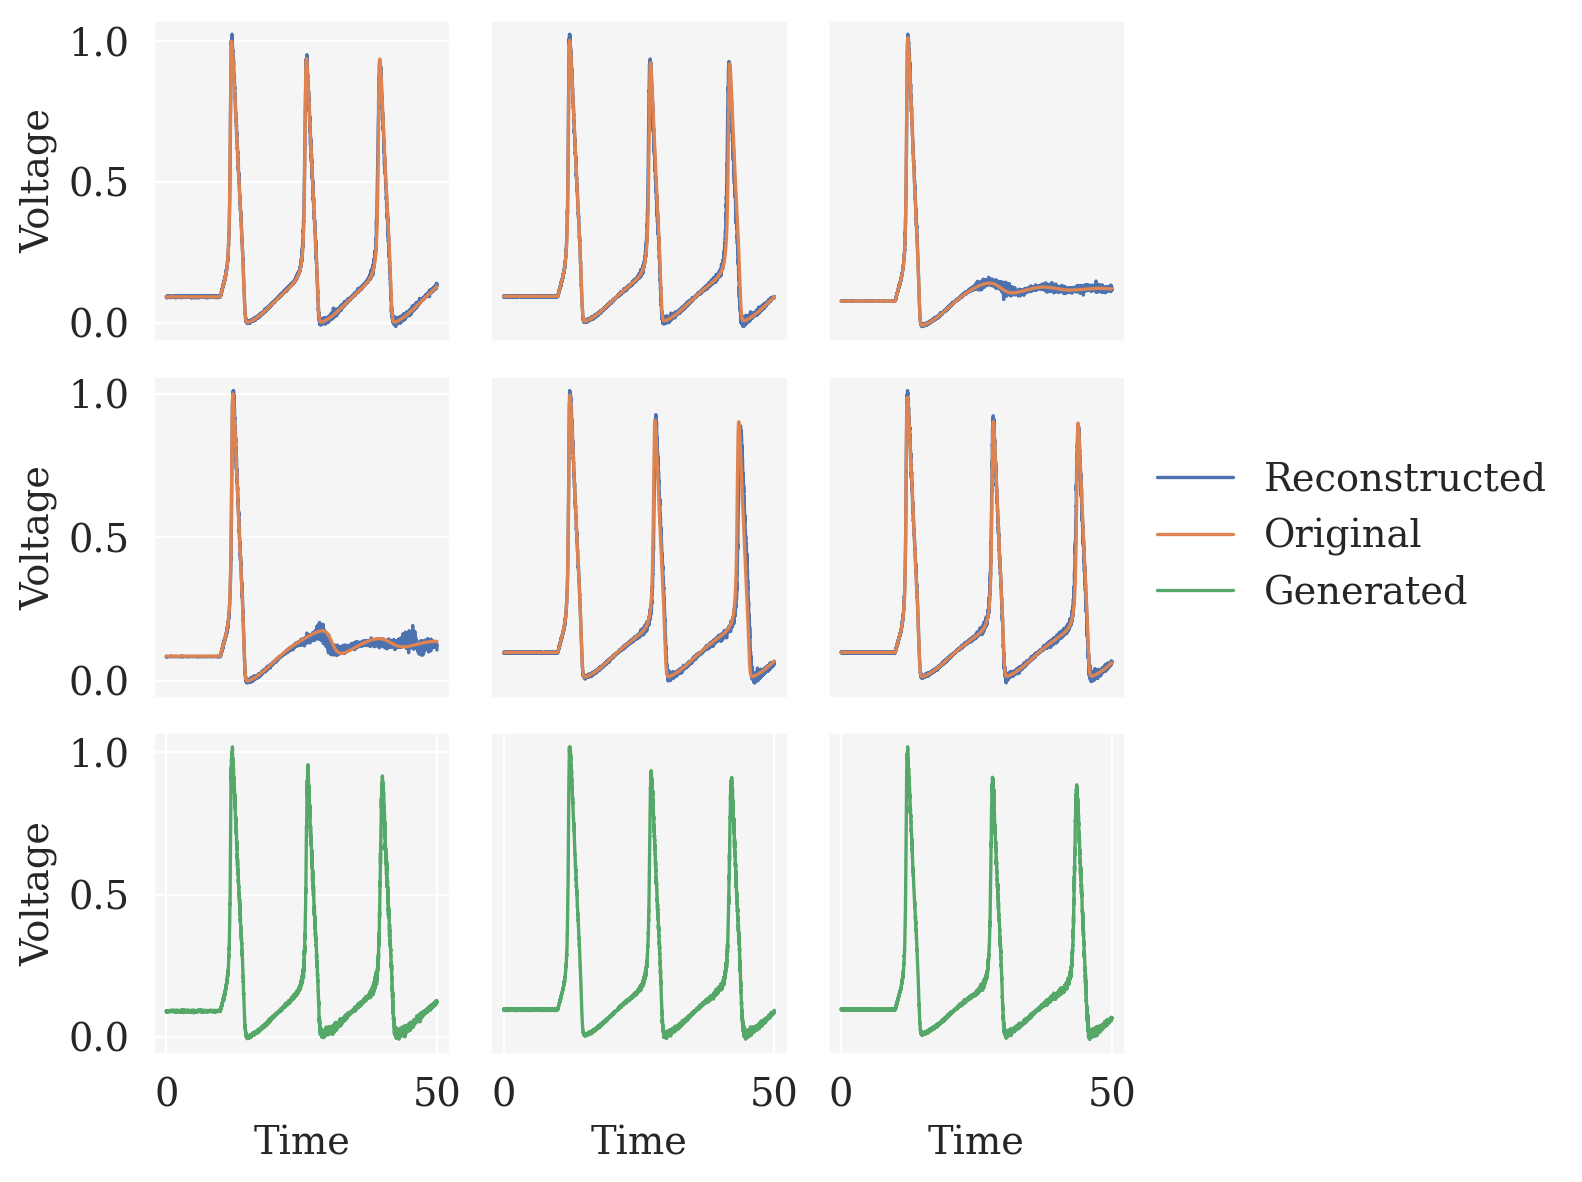

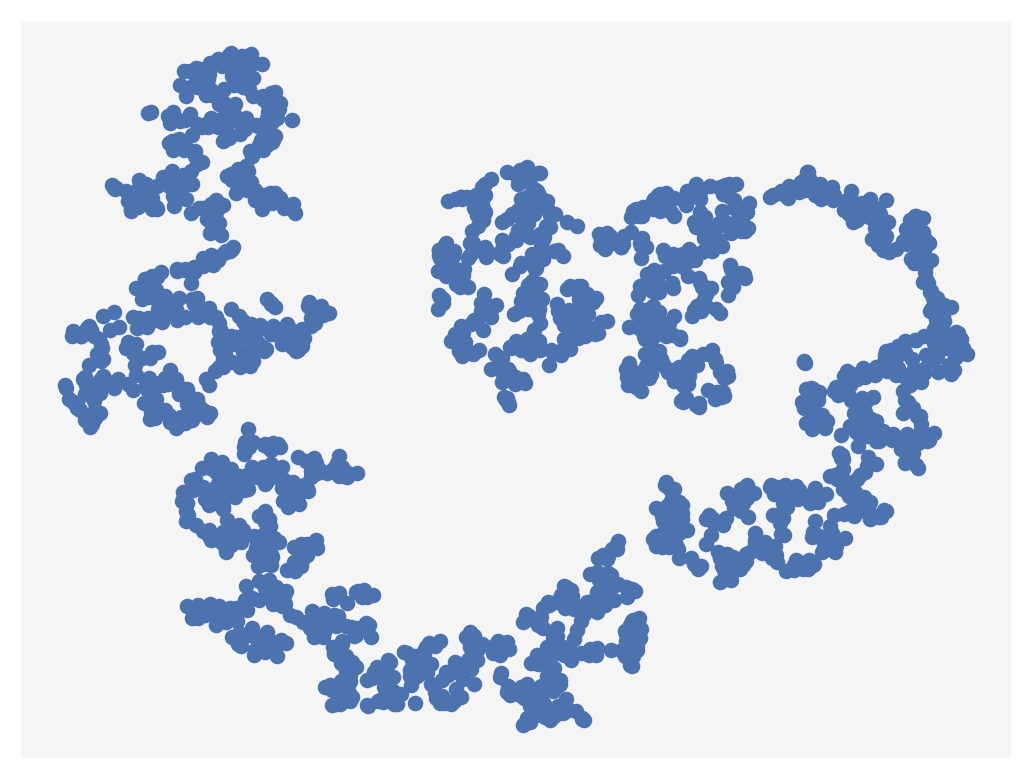

In [11]:
run(2, 2)